In [1]:
import sys
from src import model, visualization, evaluate, data, preprocessing
import src.lib.useful_functions as uf

import numpy as np
import yaml
# import pandas as pd

In [2]:
#RUN ONLY TO SAVE IMAGES LOCALLY

# data.save_imgs_2npy(meta_path='data/meta',
#             mk_folder_path='data/C02-MK/2020',
#             img_folder_path='data/C02-FR/2020',
#             destintation_path='data/images',
#             split_days_into_folders=True
#     )

In [2]:
#LOAD WHOLE DAY 
images_20, timestamp_20 = data.load_images_from_folder('data/images/dia_20',crop_region = 3)
#images_91, timestamp_91 = data.load_images_from_folder('data/images/dia_91',crop_region = 3)

In [4]:
#TEST persistence RETURN
persistence = model.Persistence()
predictions, predict_ts = persistence.predict(images_20[80], timestamp_20[80], predict_horizon = 5)
print('persistence returned', len(predictions), 'images')
print('timestamp of input image',timestamp_20[80])
print('timestamp of predicted images', predict_ts)

persistence returned 6 images
timestamp of input image 2020-01-20 13:20:17
timestamp of predicted images DatetimeIndex(['2020-01-20 13:20:17', '2020-01-20 13:30:17',
               '2020-01-20 13:40:17', '2020-01-20 13:50:17',
               '2020-01-20 14:00:17', '2020-01-20 14:10:17'],
              dtype='datetime64[ns]', freq='10T')


In [7]:
#TEST evaluate.evaluate_image RETURN

predict_errors = evaluate.evaluate_image(predictions, images_20[80:86], metric='FS',  pixel_max_value =255)
print('error comparing with images in ground truth' , predict_errors)


error comparing with images in ground truth [1, 0.0, 0.0, 0.0, 0.0, 0.0]


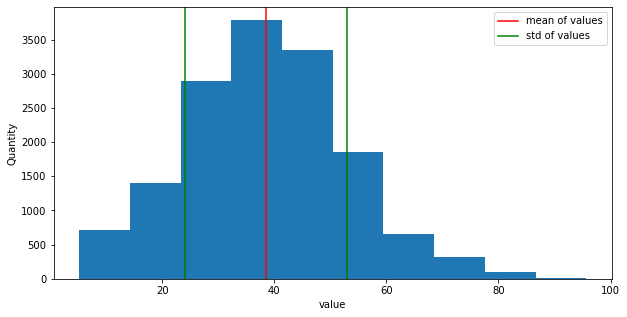

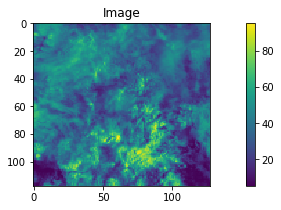

In [14]:
visualization.plot_histogram(images_20[80],bins=10,normalize=False)
visualization.show_image_w_colorbar(images_20[80])

In [69]:
#ERROR CALCULATOR WHEN WHOLE DAY LOADED

predict_horizon = 10
error_p_list =[] #used for persistence
error_bp_list =[] #used for blurred persistence
 
 

for i in range(len(images_20)):
    if (i < len(images_20)-predict_horizon):
        predictions_p, _ = model.persitence(images_20[i], timestamp_20[i], predict_horizon)
        predictions_bp, _ = model.blurred_persitence(images_20[i], timestamp_20[i], predict_horizon,kernel_size=(11,11))
        
        
        predict_errors_p = evaluate.evaluate_image(predictions_p, images_20[i+1:i+predict_horizon+1], 
                                                metric='FS',  pixel_max_value =255)
        predict_errors_bp = evaluate.evaluate_image(predictions_bp, images_20[i+1:i+predict_horizon+1], 
                                                metric='FS',  pixel_max_value =255)
        
    else: #starts predicting images outside the day
        
        predictions_p, _ = model.persitence(images_20[i], timestamp_20[i], len(images_20)-(i+1))
        predictions_bp, _ = model.blurred_persitence(images_20[i], timestamp_20[i], len(images_20)-(i+1),kernel_size=(11,11))
        
        predict_errors_p = evaluate.evaluate_image(predictions_p, images_20[i+1:], 
                                                metric='FS',  pixel_max_value =255)
        predict_errors_bp = evaluate.evaluate_image(predictions_bp, images_20[i+1:], 
                                                metric='FS',  pixel_max_value =255)
        
        for _ in range(predict_horizon+1 - (len(images_20)-i)):
            #puts 0 in errors for predictions outside the day
            predict_errors_p.append(0)
            predict_errors_bp.append(0)
        
    error_p_list.append(predict_errors_p)
    error_bp_list.append(predict_errors_bp)
    
    
print('Predicted for',len(error_p_list), 'images')

error_p_array = np.array(error_p_list)
error_bp_array = np.array(error_bp_list)

print(error_p_array.shape)
    

Predicted for 144 images
(144, 10)


In [15]:
#CMV test

# Load configuration
stream = open("les-prono/admin_scripts/config.yaml", 'r')
dcfg = yaml.load(stream, yaml.FullLoader)  # dict

error_cmv1_list = [] #used for cmv1
error_cmv2_list = [] #used for cmv2

predict_horizon = 10

for i in range(len(images_20)-1):
    if (i < len(images_20)-predict_horizon):
        predictions_cmv1 = model.cmv1(dcfg=dcfg, 
                                    imgi=images_20[i],
                                    imgf=images_20[i+1], 
                                    period=10*60,
                                    delta_t=10*60, 
                                    predict_horizon= predict_horizon)
        
        predictions_cmv2 = model.cmv2(dcfg=dcfg, 
                                    imgi=images_20[i],
                                    imgf=images_20[i+1], 
                                    period=10*60,
                                    delta_t=10*60, 
                                    predict_horizon= predict_horizon)
          
        predict_errors_cmv1 = evaluate.evaluate_image(predictions_cmv1, images_20[i+1:i+predict_horizon+1], 
                                                metric='FS',  pixel_max_value =255)
        predict_errors_cmv2 = evaluate.evaluate_image(predictions_cmv2, images_20[i+1:i+predict_horizon+1], 
                                                metric='FS',  pixel_max_value =255)

        
    else: #starts predicting images outside the day
        
        predictions_cmv1 = model.cmv1(dcfg=dcfg, 
                                    imgi=images_20[i],
                                    imgf=images_20[i+1], 
                                    period=10*60,
                                    delta_t=10*60, 
                                    predict_horizon= len(images_20)-(i+1))
        predictions_cmv2 = model.cmv2(dcfg=dcfg, 
                                    imgi=images_20[i],
                                    imgf=images_20[i+1], 
                                    period=10*60,
                                    delta_t=10*60, 
                                    predict_horizon= len(images_20)-(i+1))
            
        predict_errors_cmv1 = evaluate.evaluate_image(predictions_cmv1, images_20[i+1:], 
                                                metric='FS',  pixel_max_value =255)
        predict_errors_cmv2 = evaluate.evaluate_image(predictions_cmv2, images_20[i+1:], 
                                                metric='FS',  pixel_max_value =255)
        
        for _ in range(predict_horizon+1 - (len(images_20)-i)):
            #puts 0 in errors for predictions outside the day
            predict_errors_cmv1.append(0)
            predict_errors_cmv2.append(0)
    
    error_cmv1_list.append(predict_errors_cmv1)
    error_cmv2_list.append(predict_errors_cmv2)

error_cmv1_array = np.array(error_cmv1_list)
error_cmv2_array = np.array(error_cmv2_list)

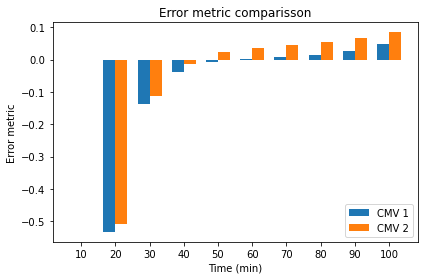

In [16]:
#Slice day in 70:100 to leave night time out

mean_error_cmv1 = np.mean(error_cmv1_array[70:100],axis=0)
mean_error_cmv2 = np.mean(error_cmv2_array[70:100],axis=0)


# visualization.barchart_compare3(mean_error_p, 'Persitence',
#                  mean_error_bp, 'Blurred Persitence',
#                  mean_error_cmv, 'CMV')

visualization.barchart_compare2(mean_error_cmv1, 'CMV 1',
                 mean_error_cmv2, 'CMV 2')
#barchart_compare(mean_error_cmv,mean_error_p)

In [8]:
#Testing for batch loading . Not working yet

current_imgs = []
predict_horizon = 10
files_total = len(os.listdir('data/images/dia_20'))

time_stamp = []
error_p_list = []

current_imgs, time_stamp, last_img_filename = data.load_by_batches(folder='data/images/dia_20', 
                                                          current_imgs=current_imgs, 
                                                          time_stamp= time_stamp, 
                                                          list_size= predict_horizon + 1, 
                                                          last_img_filename= None)

predictions_p, _ = model.persitence(current_imgs[0], time_stamp[0], predict_horizon)
predict_errors_p = evaluate.evaluate_image(predictions_p, current_imgs[1:], metric='RMSE')

error_p_list.append(predict_errors_p)

for _ in range():
    
    
    current_imgs, time_stamp, last_img_filename = data.load_by_batches(folder='data/images/dia_20', 
                                                            current_imgs=current_imgs, 
                                                            time_stamp= time_stamp, 
                                                            list_size= predict_horizon + 1, 
                                                            last_img_filename= last_img_filename)

TypeError: range expected 1 argument, got 0

In [50]:
visualization.save_errorarray_as_csv(error_cmv2_array,timestamp_20, 'prueba')

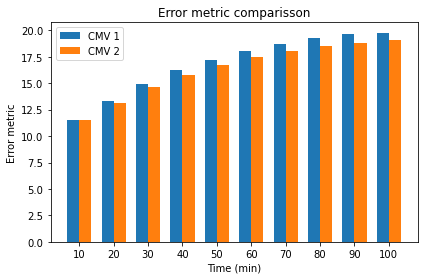

In [4]:
#Slice day in 70:100 to leave night time out

# mean_error_p = np.mean(error_p_array[70:100],axis=0)
# mean_error_bp = np.mean(error_bp_array[70:100],axis=0)
mean_error_cmv1 = np.mean(error_cmv1_array[70:100],axis=0)
mean_error_cmv2 = np.mean(error_cmv2_array[70:100],axis=0)


# visualization.barchart_compare3(mean_error_p, 'Persitence',
#                  mean_error_bp, 'Blurred Persitence',
#                  mean_error_cmv, 'CMV')

visualization.barchart_compare2(mean_error_cmv1, 'CMV 1',
                 mean_error_cmv2, 'CMV 2')
#barchart_compare(mean_error_cmv,mean_error_p)

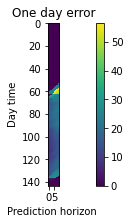

In [71]:
visualization.matrix_graph(error_p_array)
#visualization.matrix_graph(error_gp_array)

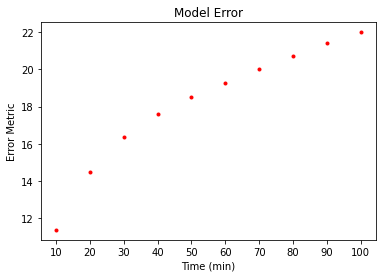

In [ ]:
visualization.plot_graph(mean_error_p)

In [5]:
def main_test(model_instance):
    images_day = images_20
    timestamp_day = timestamp_20
    predict_horizon = 30
    error_list =[]

    cmv_shift = 1 if isinstance(model_instance, model.Cmv) else 0
    for i in range(len(images_day)-cmv_shift):
        print(i)
        #set predict_horizon/ground_truths
        if (i < len(images_day)-predict_horizon-cmv_shift):
            predict_horizon_aux = predict_horizon
            ground_truths = images_day[i+cmv_shift:i+predict_horizon+1+cmv_shift]
        else: 
            predict_horizon_aux = len(images_day)-(i+1)-cmv_shift
            ground_truths = images_day[i+cmv_shift:]
        
        #predict depending on model
        if (isinstance(model_instance, model.Persistence)):
            predictions, _ = model_instance.predict(images_day[i], timestamp_day[i], predict_horizon_aux)
            dynamic_window = False
        elif (isinstance(model_instance, model.Cmv)):
            predictions = model_instance.predict(imgi=images_day[i], imgf=images_day[i+1], 
                period=10*60, delta_t=10*60, predict_horizon=predict_horizon_aux) 
            dynamic_window = False

        #evaluate
        predict_errors = evaluate.evaluate_image(predictions, ground_truths, 
            metric='RMSE',  pixel_max_value=255, dynamic_window=dynamic_window)

        for _ in range(predict_horizon+1 - len(predict_errors)):
            #puts 0 in errors for predictions outside the day
            predict_errors.append(0)

        error_list.append(predict_errors)
        
    print('Predicted for',len(error_list), 'images')
    error_array = np.array(error_list)
    print(error_array.shape)
    visualization.matrix_graph(error_array)

    # mean_error = np.mean(error_array[70:100],axis=0)
    # visualization.plot_graph(mean_error)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
Predicted for 143 images
(143, 31)


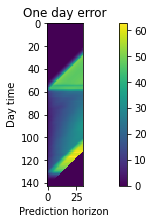

In [6]:
# pers = model.Persistence()
# persN = model.NoisyPersistence(sigma=1)
# persB = model.BlurredPersistence(kernel_size=(11,11))
# cmv1 = model.Cmv1()
cmv2 = model.Cmv2()

# main_test(pers)
# main_test(persN)
# main_test(persB)
# main_test(cmv1)
main_test(cmv2)

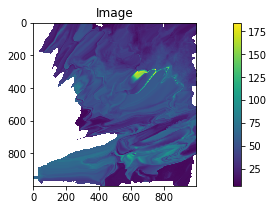

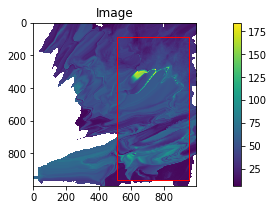

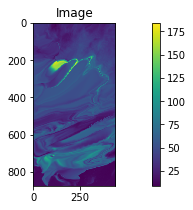

In [10]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

def find_inner_image(image):
    step = 5
    found_xmin = found_ymin = found_xmax = found_ymax = False
    xmin = ymin = xmax = ymax = 0
    while(not (found_xmin and found_ymin and found_xmax and found_ymax)):
        range_x = len(image[0]) - (xmin+xmax)
        range_y = len(image[0]) - (ymin+ymax)
        found_xmin_aux = found_ymin_aux = found_xmax_aux = found_ymax_aux = True
        for i in range(range_x):
            if (found_ymin == False and found_ymin_aux == True and np.isnan(image[xmin+i][ymin])):
                ymin += step
                found_ymin_aux = False
            if (found_ymax == False and found_ymax_aux == True and np.isnan(image[-(xmax+i+1)][-(ymax+1)])):
                ymax += step
                found_ymax_aux = False
            if (i == range_x-1):
                found_ymin = found_ymin_aux
                found_ymax = found_ymax_aux

        for i in range(range_y):
            if (found_xmin == False and found_xmin_aux == True and np.isnan(image[xmin][ymin+i]) ):
                xmin += step
                found_xmin_aux = False
            if (found_xmax == False and found_xmax_aux == True and np.isnan(image[-(xmax+1)][-(ymax+i+1)])):
                xmax += step
                found_xmax_aux = False
            if (i == range_y-1):
                found_xmin = found_xmin_aux
                found_xmax = found_xmax_aux
    #return xmin, xmax, ymin, ymax
    #return image[xmin:-xmax, ymin:-ymax]
  
    visualization.show_image_w_colorbar(image) 

    fig, (ax1) = plt.subplots(figsize=(13, 3), ncols=1)
    image_ = ax1.imshow(image, interpolation='none')
    fig.colorbar(image_, ax=ax1)
    ax1.title.set_text('Image')

    rect = patches.Rectangle((ymin, xmin), len(image)-(ymin+ymax), len(image)-(xmin+xmax), linewidth=1, edgecolor='r', facecolor='none')
    ax1.add_patch(rect)
    plt.show()

    visualization.show_image_w_colorbar(image [xmin:len(image)-xmax, ymin:len(image)-ymax] )


cmv2 = model.Cmv2()
predict_horizon_aux = 30
predictions = cmv2.predict(imgi=images_20[127], imgf=images_20[127+1],  #127
                period=10*60, delta_t=10*60, predict_horizon=predict_horizon_aux) 

find_inner_image(predictions[-1])
#find_inner_image(images_20[-1])

 # Optuna test

In [20]:
import time 
def main_test(model_instance,dl_sw, trial=None):
    predict_horizon_full = dl_sw.dataset.window-2
    error_list =[]
    error_list_day = []

    per_predict_time= []
    eval_time = []
    cmv_predict_time = []
    
    for idx, samples in enumerate(dl_sw):

        predict_horizon = samples['images'].shape[0] - 2
        if predict_horizon == 0:
            break

        if idx%50 == 0:
           print(idx)
        
        #predict depending on model
        if (isinstance(model_instance, model.Persistence)):
            start = time.time()
            predictions, prediction_ts = model_instance.predict(
                                    samples['images'][1], 
                                    samples['time_stamps'][1], 
                                    predict_horizon)
            end = time.time()
            per_predict_time.append(end-start)
            dynamic_window = False
        elif (isinstance(model_instance, model.Cmv)):
            start = time.time()
            predictions , cmv_ts = model_instance.predict(
                                    imgi=samples['images'][0, :, :], 
                                    imgf=samples['images'][1, :, :],
                                    imgf_ts = samples['time_stamps'][1], 
                                    period=10*60, delta_t=10*60, 
                                    predict_horizon=predict_horizon, 
                                    trial=trial)  #adds trial to predict
            end = time.time()
            cmv_predict_time.append(end-start)
            dynamic_window = True

        #evaluate
        start = time.time()
        predict_errors = evaluate.evaluate_image(
                                                predictions = predictions, 
                                                gt = samples['images'][1:], 
                                                gt_ts = samples['time_stamps'][1:],
                                                metric='RMSE', dynamic_window=dynamic_window,
                                                evaluate_day_pixels = False)
        for _ in range(predict_horizon_full+1 - len(predict_errors)):
            #adds 0 in errors for predictions outside the day
            predict_errors.append(0)

        error_list.append(predict_errors)
        end = time.time()
        eval_time.append(end-start)
        # predict_errors_day = evaluate.evaluate_image(
        #                                         predictions = predictions, 
        #                                         gt = samples['images'][1:], 
        #                                         gt_ts = samples['time_stamps'][1:],
        #                                         metric='RMSE', dynamic_window=dynamic_window,
        #                                         evaluate_day_pixels = True)
        # for _ in range(predict_horizon_full+1 - len(predict_errors)):
        #     #adds 0 in errors for predictions outside the day
        #     predict_errors.append(0)
        # error_list_day.append(predict_errors_day)
    print('persistence predict time: ', np.sum(per_predict_time))
    print('cmv predict time: ', np.sum(cmv_predict_time))
    print('evaluation time: ', np.sum(eval_time))

    return np.mean(np.vstack(error_list))
    # return error_list , error_list_day


In [22]:
import optuna
from torch.utils.data import DataLoader

def get_data():
    predict_horizon = 10
    dataset_sw = data.SatelliteImagesDatasetSW(root_dir = 'data/images/dia_305', 
                                           window = predict_horizon+2,
                                           transform = preprocessing.CropImage(3))
    dl_sw = DataLoader(dataset_sw, batch_size=1, collate_fn=data.collate_fn_sw)
    return dl_sw


class Objective(object):
    def __init__(self, model_instance):
        # Hold this implementation specific arguments as the fields of the class.
        self.model_instance = model_instance

    def __call__(self, trial):
        # Calculate an objective value by using the extra arguments.
        dl_sw = get_data()
        return main_test(self.model_instance,dl_sw, trial)

cmv = model.Cmv2()

# Execute an optimization by using an `Objective` instance.
study = optuna.create_study()
study.optimize(Objective(cmv), n_trials=2)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-04-27 01:55:23,336] A new study created in memory with name: no-name-8694cf5a-dd0c-42f1-9f35-c672a0e78d22
0
50
100
[I 2021-04-27 01:57:01,690] Trial 0 finished with value: 6.961886777443556 and parameters: {'pyr_scale': 0.4985230276152181}. Best is trial 0 with value: 6.961886777443556.
persistence predict time:  0.0
cmv predict time:  74.67347383499146
evaluation time:  14.234281539916992
0
50
100
[I 2021-04-27 01:58:52,843] Trial 1 finished with value: 6.960272740443903 and parameters: {'pyr_scale': 0.47970187130363395}. Best is trial 1 with value: 6.960272740443903.
persistence predict time:  0.0
cmv predict time:  83.83195090293884
evaluation time:  16.602039337158203
Best trial:
  Value:  6.960272740443903
  Params: 
    pyr_scale: 0.47970187130363395
